In [1]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import optuna
import numpy as np
from sklearn.preprocessing import StandardScaler

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# Load the dataset
data = pd.read_csv('C:/Users/HP/Desktop/задание 5/Country-data.csv')

# Check for missing values or duplicates
print(data.info())
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None
country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


In [3]:
# Drop non-numerical columns
features = data.drop('country', axis=1)  # Remove the non-numerical 'country' column

# Standardize features
scaler = StandardScaler()
# Standardize the features to have mean 0 and variance 1
standardized_features = scaler.fit_transform(features)


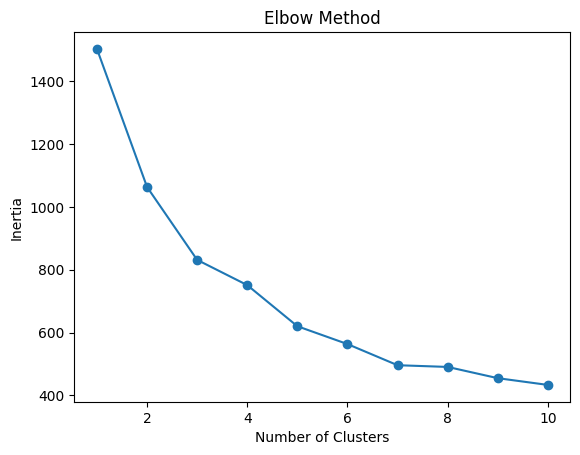

In [4]:
# Evaluate the number of clusters
## Create an empty list to store inertia values for different cluster numbers
distortions = []
# Loop through different numbers of clusters (1 to 10) to find the optimal cluster count
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(standardized_features) #Fits the K-Means model to the provided data
    #It represents the sum of squared distances of each point to its assigned cluster cente
    distortions.append(kmeans.inertia_) 
#'inertia is used to find the optimal number of clusters
# Visualize the elbow method
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

The optimal number of clusters (k) is likely 4, as indicated by the elbow point.
Beyond k=4, the reduction in inertia becomes marginal, meaning increasing the number of clusters would only add complexity without much gain in cluster compactness.

In [5]:
#Perform clustering using the optimal number of clusters.
# Based on the elbow curve, assume the optimal number of clusters is 4
kmeans = KMeans(n_clusters=4, random_state=42)
## Fit K-Means to the normalized data and predict cluster labels for each point
clusters = kmeans.fit_predict(standardized_features)

# Add cluster labels to the dataset
data['Cluster'] = clusters
print(data.head())


               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  Cluster  
0       9.44        56.2       5.82    553        2  
1       4.49        76.3       1.65   4090        0  
2      16.10        76.5       2.89   4460        0  
3      22.40        60.1       6.16   3530        2  
4       1.44        76.8       2.13  12200        0  


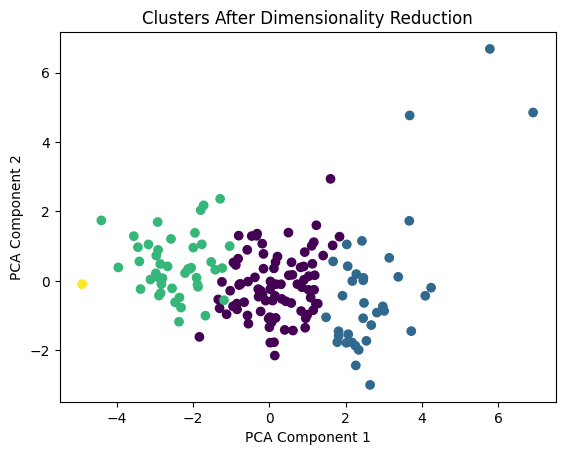

In [6]:
# Reduce to 2 components for visualization using PCA to reduces the number of dimensions
#Réduction de la dimensionnalité 
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(standardized_features)

# Visualize the clusters in PCA space
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters After Dimensionality Reduction')
plt.show() 

the results of clustering on a dataset that has been reduced to two dimensions

In [7]:
#Prepare the dataset for classification.
#The features are normalized, and the target variable is the cluster labels.
X = standardized_features  # Use normalized features
y = clusters # Cluster labels as the target variable

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Initialize and train the SVM model
## Initialize an SVM model with an RBF kernel because  the data is not linearly separable
svm_model = SVC(kernel='rbf', random_state=42) 
svm_model.fit(X_train, y_train)

# Evaluate the accuracy
y_pred_svm = svm_model.predict(X_test)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.2f}")

SVM Accuracy: 0.94


In [9]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the accuracy
y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")


Random Forest Accuracy: 1.00


The Random Forest classifier achieved perfect accuracy (
1.00
1.00), indicating its strong ability to capture complex, non-linear relationships and adapt to the clusters created by K-Means. The SVM classifier, with slightly lower accuracy (
0.94
0.94), still performs well and offers better potential generalization if hyperparameters are fine-tuned.

In [10]:
#to optimize the hyperparameters of a Random Forest classifier by maximizing its accuracy score.
def objective(trial):
    # 50 to 200 reduce the search space and save time. because the dataset is large
    n_estimators = trial.suggest_int('n_estimators', 50, 200) 
    #the range 2 to 15 keeps the model balanced between being too simple and too complex
    max_depth = trial.suggest_int('max_depth', 2, 15) 
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
     # Train the model
    rf_model.fit(X_train, y_train)
     # Predict on the test data
    y_pred = rf_model.predict(X_test)
    return accuracy_score(y_test, y_pred)
## Create a study to maximize accuracy
study = optuna.create_study(direction='maximize')
# Run 20 trials to optimize hyperparameters
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)

[I 2024-12-11 20:59:54,627] A new study created in memory with name: no-name-a2c939a6-9d23-4a01-8b2f-65753f217cef
[I 2024-12-11 20:59:54,846] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 186, 'max_depth': 12}. Best is trial 0 with value: 1.0.
[I 2024-12-11 20:59:54,900] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 52, 'max_depth': 9}. Best is trial 0 with value: 1.0.
[I 2024-12-11 20:59:55,012] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 107, 'max_depth': 5}. Best is trial 0 with value: 1.0.
[I 2024-12-11 20:59:55,196] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 173, 'max_depth': 14}. Best is trial 0 with value: 1.0.
[I 2024-12-11 20:59:55,296] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 86, 'max_depth': 13}. Best is trial 0 with value: 1.0.
[I 2024-12-11 20:59:55,512] Trial 5 finished with value: 0.9705882352941176 and parameters: {'n_estimators': 197, 'max_depth': 2}. Best is t

Best hyperparameters: {'n_estimators': 186, 'max_depth': 12}


In [11]:
import optuna.visualization as vis

# Visualize the optimization history
fig = vis.plot_optimization_history(study)
fig.show()

# Visualize the importance of hyperparameters
fig2 = vis.plot_param_importances(study)
fig2.show()


In [12]:
#Check Clustering Stability
#Create synthetic data based on the distributions of the original dataset.
synthetic_data = np.random.normal(loc=np.mean(standardized_features, axis=0), # Mean for each feature (column)
                                  scale=np.std(standardized_features, axis=0), # Standard deviation for each feature (column)
                                  size=(100, standardized_features.shape[1])) # 100 samples, same number of features as original data

In [13]:
## Loop to test different numbers of clusters (2 to 5) on synthetic data
for k in [2, 3, 4, 5]:
    # Initialize K-Means with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
     # Fit the model on synthetic data
    clusters = kmeans.fit_predict(synthetic_data)
    print(f"Number of Clusters: {k}, Inertia: {kmeans.inertia_}")


Number of Clusters: 2, Inertia: 739.1050910337185
Number of Clusters: 3, Inertia: 688.0567486503091
Number of Clusters: 4, Inertia: 630.4133422043292
Number of Clusters: 5, Inertia: 593.5151051142868


In [14]:
# Make predictions on synthetic data
synthetic_predictions = rf_model.predict(synthetic_data)
print("Synthetic predictions:", synthetic_predictions)


Synthetic predictions: [2 1 0 0 0 0 0 2 1 2 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 2 2 2 0 0 0 2 2 2 0
 0 0 2 0 0 0 0 0 1 0 0 2 0 0 2 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 2 2 2 1 0 0 0 0 0 0 0]


make prediction to ensure:
The robustness and generalizability of the model.
The stability and consistency of the detected clusters

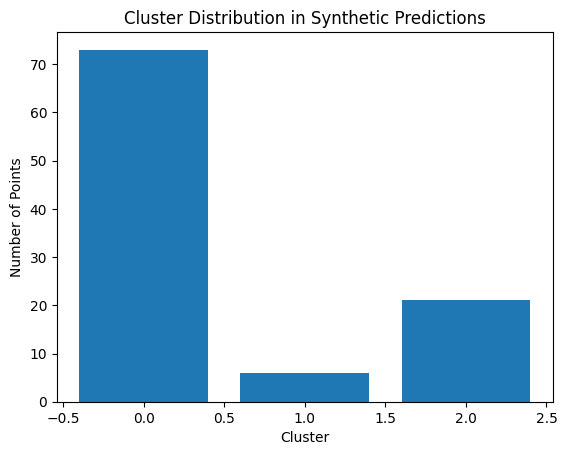

In [15]:
# Count occurrences of each cluster in the synthetic predictions
unique, counts = np.unique(synthetic_predictions, return_counts=True)
cluster_distribution = dict(zip(unique, counts))

# Bar plot of the cluster distribution
plt.bar(cluster_distribution.keys(), cluster_distribution.values())
plt.xlabel('Cluster')
plt.ylabel('Number of Points')
plt.title('Cluster Distribution in Synthetic Predictions')
plt.show()

Cluster 0 dominates
Cluster 1 has very few points
Cluster 2 has a moderate number of points

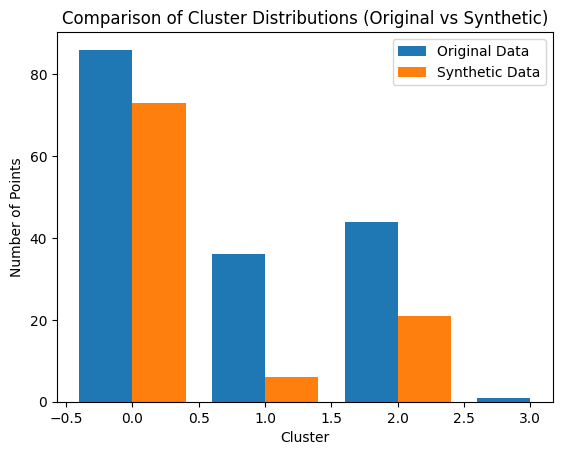

In [16]:
# Original cluster distribution
original_distribution = data['Cluster'].value_counts().sort_index()

# Synthetic prediction distribution
synthetic_distribution = pd.Series(synthetic_predictions).value_counts().sort_index()

# Plot comparison
plt.bar(original_distribution.index - 0.2, original_distribution.values, width=0.4, label='Original Data')
plt.bar(synthetic_distribution.index + 0.2, synthetic_distribution.values, width=0.4, label='Synthetic Data')
plt.xlabel('Cluster')
plt.ylabel('Number of Points')
plt.title('Comparison of Cluster Distributions (Original vs Synthetic)')
plt.legend()
plt.show()
